In [1]:
#In this notebook, we develop a simple recommender system for movies.
#This implementation is based on the Pandas implemetaion from https://stackabuse.com/creating-a-simple-recommender-system-in-python-using-pandas/
#and Spark implementataion from

In [2]:
!pip install pyspark

In [3]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.pandas as ps
ps.set_option('plotting.backend','matplotlib')

/Users/xiaoqin/opt/anaconda3/lib/python3.9/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(
23/07/26 12:20:49 WARN Utils: Your hostname, iMac.local resolves to a loopback address: 127.0.0.1; using 192.168.0.30 instead (on interface en1)
23/07/26 12:20:49 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/26 12:20:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
#Load the ratings dataset
ratings_data = ps.read_csv("ratings.csv")
print(ratings_data.shape)
ratings_data.head()

/Users/xiaoqin/opt/anaconda3/lib/python3.9/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


(100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
ratings_data['userId'].unique().shape[0]

610

In [6]:
#Load the movies dataset
movie_names=ps.read_csv("movies.csv")
print(movie_names.shape)
movie_names.head()

/Users/xiaoqin/opt/anaconda3/lib/python3.9/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


(9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
#Join movies and ratings
movie_data=ps.merge(ratings_data,movie_names,on='movieId',how='left')
movie_data.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [8]:
ratings_data.shape[0],movie_data.shape[0]

(100836, 100836)

In [9]:
#Calculate sparsity percentage
def get_mat_sparsity(ratings):
  #count the toal number of rating in the dataset
  count_nonzero=ratings[~ratings["rating"].isna()].shape[0]

  #count the number of distict userIds and distinct movieIds
  total_elements=ratings['userId'].unique().shape[0]*ratings['movieId'].unique().shape[0]

  #Divide the numerator by the denominator
  sparsity=(1.0-(count_nonzero*1.0)/total_elements)*100
  print("This ratings dataframe is ","%.2f"%sparsity+"%sparse.")

get_mat_sparsity(ratings_data)

This ratings dataframe is  98.30%sparse.


In [10]:
#Average rating per movie
movie_data.groupby('title').agg(mean_rating=('rating','mean')).sort_values('mean_rating',ascending=False).head()

,mean_rating
title,
National Lampoon's Bag Boy (2007),5.0
Zeitgeist: Moving Forward (2011),5.0
English Vinglish (2012),5.0
Martin Lawrence Live: Runteldat (2002),5.0
Bill Hicks: Revelations (1993),5.0


In [11]:
#count of rating per movie
movie_data.groupby('title').agg(rating_counts=('rating','count')).sort_values('rating_counts',ascending=False).head()

,rating_counts
title,
Forrest Gump (1994),329
"Shawshank Redemption, The (1994)",317
Pulp Fiction (1994),307
"Silence of the Lambs, The (1991)",279
"Matrix, The (1999)",278


In [12]:
#count and mean rating per movie
ratings_mean_count = movie_data.groupby('title').agg(mean_rating=('rating', 'mean'), rating_counts=('rating', 'count')).sort_values('mean_rating', ascending=False)
ratings_mean_count.head()

,mean_rating,rating_counts
title,,
National Lampoon's Bag Boy (2007),5.0,1
Zeitgeist: Moving Forward (2011),5.0,1
English Vinglish (2012),5.0,1
Martin Lawrence Live: Runteldat (2002),5.0,1
Bill Hicks: Revelations (1993),5.0,1


UsageError: Line magic function `%matplot` not found.


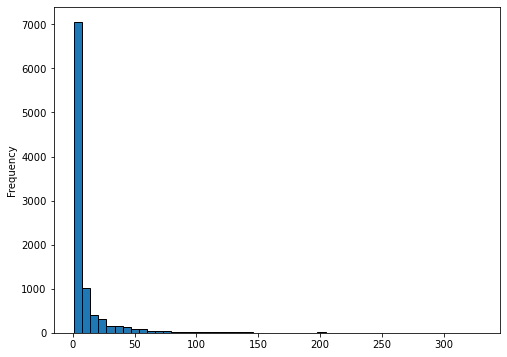

In [13]:
#Hsitogram of rating count
#ratings_mean_count_pd=ratings_mean_count.to_pandas()
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor']=True
ratings_mean_count['rating_counts'].hist(bins=50)
%matplot plt

UsageError: Line magic function `%matplot` not found.


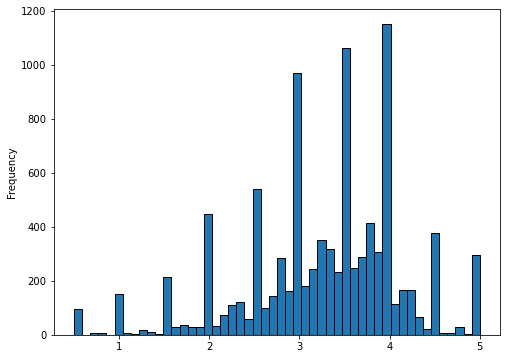

In [14]:
#historgram of average ratings
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor']=True
ratings_mean_count['mean_rating'].hist(bins=50)
%matplot plt

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor']=True
ratings_mean_count.plot.scatter('mean_rating','rating_counts')
%matplot plt

In [ ]:
#the scatter plt with full df looks very different due to sampling used with ps.plot
ratings_mean_count_pd=ratings_mean_count.to_pandas()
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor']=True
plt.scatter(ratings_mean_count_pd['mean_rating'],ratings_mean_count_pd['rating_counts'])
%matplot plt

In [15]:
#Split into train and test partitions
(train, test) = ratings_data.to_spark().randomSplit([0.8, 0.2], seed = 2020)

/Users/xiaoqin/opt/anaconda3/lib/python3.9/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [16]:
#Building an ALS model
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator#create ALS model
als = ALS(
         userCol="userId",
         itemCol="movieId",
         ratingCol="rating",
         nonnegative = True,
         implicitPrefs = False,
         coldStartStrategy="drop"
)

In [17]:
#rank is number of features to use for each matrix
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [10, 50, 100, 150]) \
            .addGrid(als.regParam, [.01, .05, .1, .15]) \
            .build()

In [18]:
evaluator = RegressionEvaluator(
           metricName="rmse",
           labelCol="rating",
           predictionCol="prediction")
print ("Num models to be tested: ", len(param_grid))

Num models to be tested:  16


In [19]:
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

In [20]:
#Run grid search using 5-fold cross validation
#Fit cross validator to the 'train' dataset
model = cv.fit(train)#Extract best model from the cv model above
best_model = model.bestModel# View the predictions
test_predictions = best_model.transform(test)
RMSE = evaluator.evaluate(test_predictions)
print(RMSE)

23/07/26 12:21:43 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


0.8712108929062686


In [26]:
#Check the best model parameters
print("**Best Model**")
print("  Rank:", best_model._java_obj.parent().getRank())
print("  MaxIter:", best_model._java_obj.parent().getMaxIter())
print("  RegParam:", best_model._java_obj.parent().getRegParam())

**Best Model**
  Rank: 150
  MaxIter: 10
  RegParam: 0.15


In [27]:
#Generate recommendations
#Generate 5 Recommendatyions fro each user
nrecommendations=best_model.recommendForAllUsers(5)
nrecommendations.head()

Row(userId=1, recommendations=[Row(movieId=3379, rating=5.773260116577148), Row(movieId=132333, rating=5.672050476074219), Row(movieId=5490, rating=5.672050476074219), Row(movieId=171495, rating=5.604428768157959), Row(movieId=33649, rating=5.60233736038208)])

In [28]:
#Convert recommendations into interpretable format
nrecommendations=nrecommendations\
                 .withColumn("rec_exp",F.explode("recommendations"))\
                 .select('userId',F.col("rec_exp.movieId"),F.col("rec_exp.rating"))
nrecommendations.limit(10).show()

+------+-------+---------+
|userId|movieId|   rating|
+------+-------+---------+
|     1|   3379|  5.77326|
|     1| 132333|5.6720505|
|     1|   5490|5.6720505|
|     1| 171495| 5.604429|
|     1|  33649|5.6023374|
|     2|  33649| 4.713321|
|     2|   3379| 4.692937|
|     2| 171495| 4.673063|
|     2| 184245| 4.663832|
|     2| 179135| 4.663832|
+------+-------+---------+



In [30]:
#Do the recommendations make sense?
nrecommendations.join(movie_names.to_spark(), on='movieId').filter('userId = 100').show()

+-------+------+---------+--------------------+--------------------+
|movieId|userId|   rating|               title|              genres|
+-------+------+---------+--------------------+--------------------+
|  33649|   100| 5.128347|  Saving Face (2004)|Comedy|Drama|Romance|
|  67618|   100| 4.993712|Strictly Sexual (...|Comedy|Drama|Romance|
|   7121|   100| 4.939056|   Adam's Rib (1949)|      Comedy|Romance|
| 184245|   100|4.9244256|De platte jungle ...|         Documentary|
| 179135|   100|4.9244256|Blue Planet II (2...|         Documentary|
+-------+------+---------+--------------------+--------------------+



In [31]:
#Compare with 100th user's actual preferences
movie_data[movie_data.userId==100].sort_values('rating',ascending=False).head(10)

,userId,movieId,rating,timestamp,title,genres
15355,100,1101,5.0,1100184137,Top Gun (1986),Action|Romance
15386,100,1958,5.0,1100186258,Terms of Endearment (1983),Comedy|Drama
15401,100,2423,5.0,1100186118,Christmas Vacation (National Lampoon's Christm...,Comedy
15425,100,4041,5.0,1100184235,"Officer and a Gentleman, An (1982)",Drama|Romance
15437,100,5620,5.0,1100186982,Sweet Home Alabama (2002),Comedy|Romance
15302,100,16,4.5,1100185959,Casino (1995),Crime|Drama
15303,100,17,4.5,1100184147,Sense and Sensibility (1995),Drama|Romance
15305,100,28,4.5,1100184447,Persuasion (1995),Drama|Romance
15309,100,95,4.5,1100185961,Broken Arrow (1996),Action|Adventure|Thriller
15311,100,168,4.5,1100185915,First Knight (1995),Action|Drama|Romance
